In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gcmotion as gcm

# for debugging, can be removed
gcm.utils.reload()

plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 150

%matplotlib inline

<IPython.core.display.Javascript object>

### Variables and Equations

The purpose of this tool is to calculate the orbit of different particles in a toroidal magnetic field $\vec B$ with large aspect ratio (LAR) and constant $g,I$. The orbits are calculated by solving Hamiltons equations as presented in "The theory of toroidally confined plasmas" by R. B. White,with a 4th order Runge-Kutta method

Our dynamical variables are  $\theta, P_\theta, \zeta, P_\zeta$ and $ \rho_{||}$, and they are governed through Hamilton's equations:

$$
\dot \theta = \dfrac{1}{D}\rho_{||}B^2 +\dfrac{g}{D}\bigg[ -(\mu+\rho^2_{||}B)\bigg(\dfrac{q}{\sqrt{2\psi}}\cos(\theta)\bigg)  + \dfrac{\partial \Phi}{\partial \psi_p}\bigg]
$$

$$
\dot \psi_p = \dfrac{\dot\psi}{q(\psi)} = -\dfrac{g}{D}\bigg[(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta) + \dfrac{\partial \Phi}{\partial \theta}\bigg]
$$

$$
\dot \rho_{||} = -\dfrac{1}{D}\bigg[(\mu + \rho_{||}^2B)\sqrt{2\psi}\sin(\theta) + \dfrac{\partial \Phi}{\partial \theta} \bigg]
$$

$$
\dot \zeta = \dfrac{\rho_{||}B^2}{D} - \dfrac{I}{D}\bigg[ -(\mu+\rho^2_{||}B)\bigg(\dfrac{q}{\sqrt{2\psi}}\cos(\theta)\bigg)  + \dfrac{\partial \Phi}{\partial \psi_p}\bigg]
$$

where:  $\quad B = 1 - \sqrt{2\psi}\cos(\theta)$

We can then calculate the canonical momenta as $P_\theta = \psi + \rho_{||}I$ and $P_\zeta = \rho_{||} g -\psi_p$

### Part 1: Particle Initialization and obrit calculation

In this cell we can create multiple particles independently. By setting cwp (current working particle), we chose the particle to proceed. That way we can keep all previous particles in memory and switch cwp at any point.

First we set up the Tokamak configuration, and the particle's initial conditions

In [2]:
R, a    = 6.2, 2 # Major/Minor Radius in [m]
q       = gcm.qfactor.Hypergeometric(R, a)
Bfield  = gcm.bfield.LAR(i = 0, g = 1, B0 = 5)
Efield  = gcm.efield.Radial(R, a, q, Ea = 75000, minimum = 0.9, waist_width=50)

# Create Particle
species = "p"
mu = 10e-5 # Magnetic moment
theta0 = np.pi/3
psi0 = 0.39#0.4513# times psi_wall
z0 = np.pi
Pz0 = -0.025
tspan = np.linspace(0, 1000000, 100000) # t0, tf, steps

init_cond = [theta0, psi0, z0, Pz0]

#Particle Creation
Electron1 = gcm.Particle(species, mu, init_cond, tspan, R, a, q, Bfield, Efield)
cwp = Electron1

events = []#[cwp.events("single_theta_period")]
cwp.run(events=events)

Constants of motion:
	Particle Energy (normalized):	E  = 1.114589e-04
	Particle Energy (eV):		E  = 7.557330e+03 eV
	Particle Energy (J):		E  = 1.210818e-15 J
	Toroidal Momenta:		Pζ = -0.025

Other Quantities:
	Particle of Species:		"p"
	Orbit Type:			Trapped - Lost
	Major Radius:			R = 6.2 meters
	Minor Radius:			α = 2 meters
	Toroidal Flux at wall:		ψ = 0.0520291
	Time unit:			ω = 4.789417e+08 Hz 
	Energy unit:			E = 1.474845e-08 J 

Orbit calculation time: 1.9568s.


### Part 2: Plots

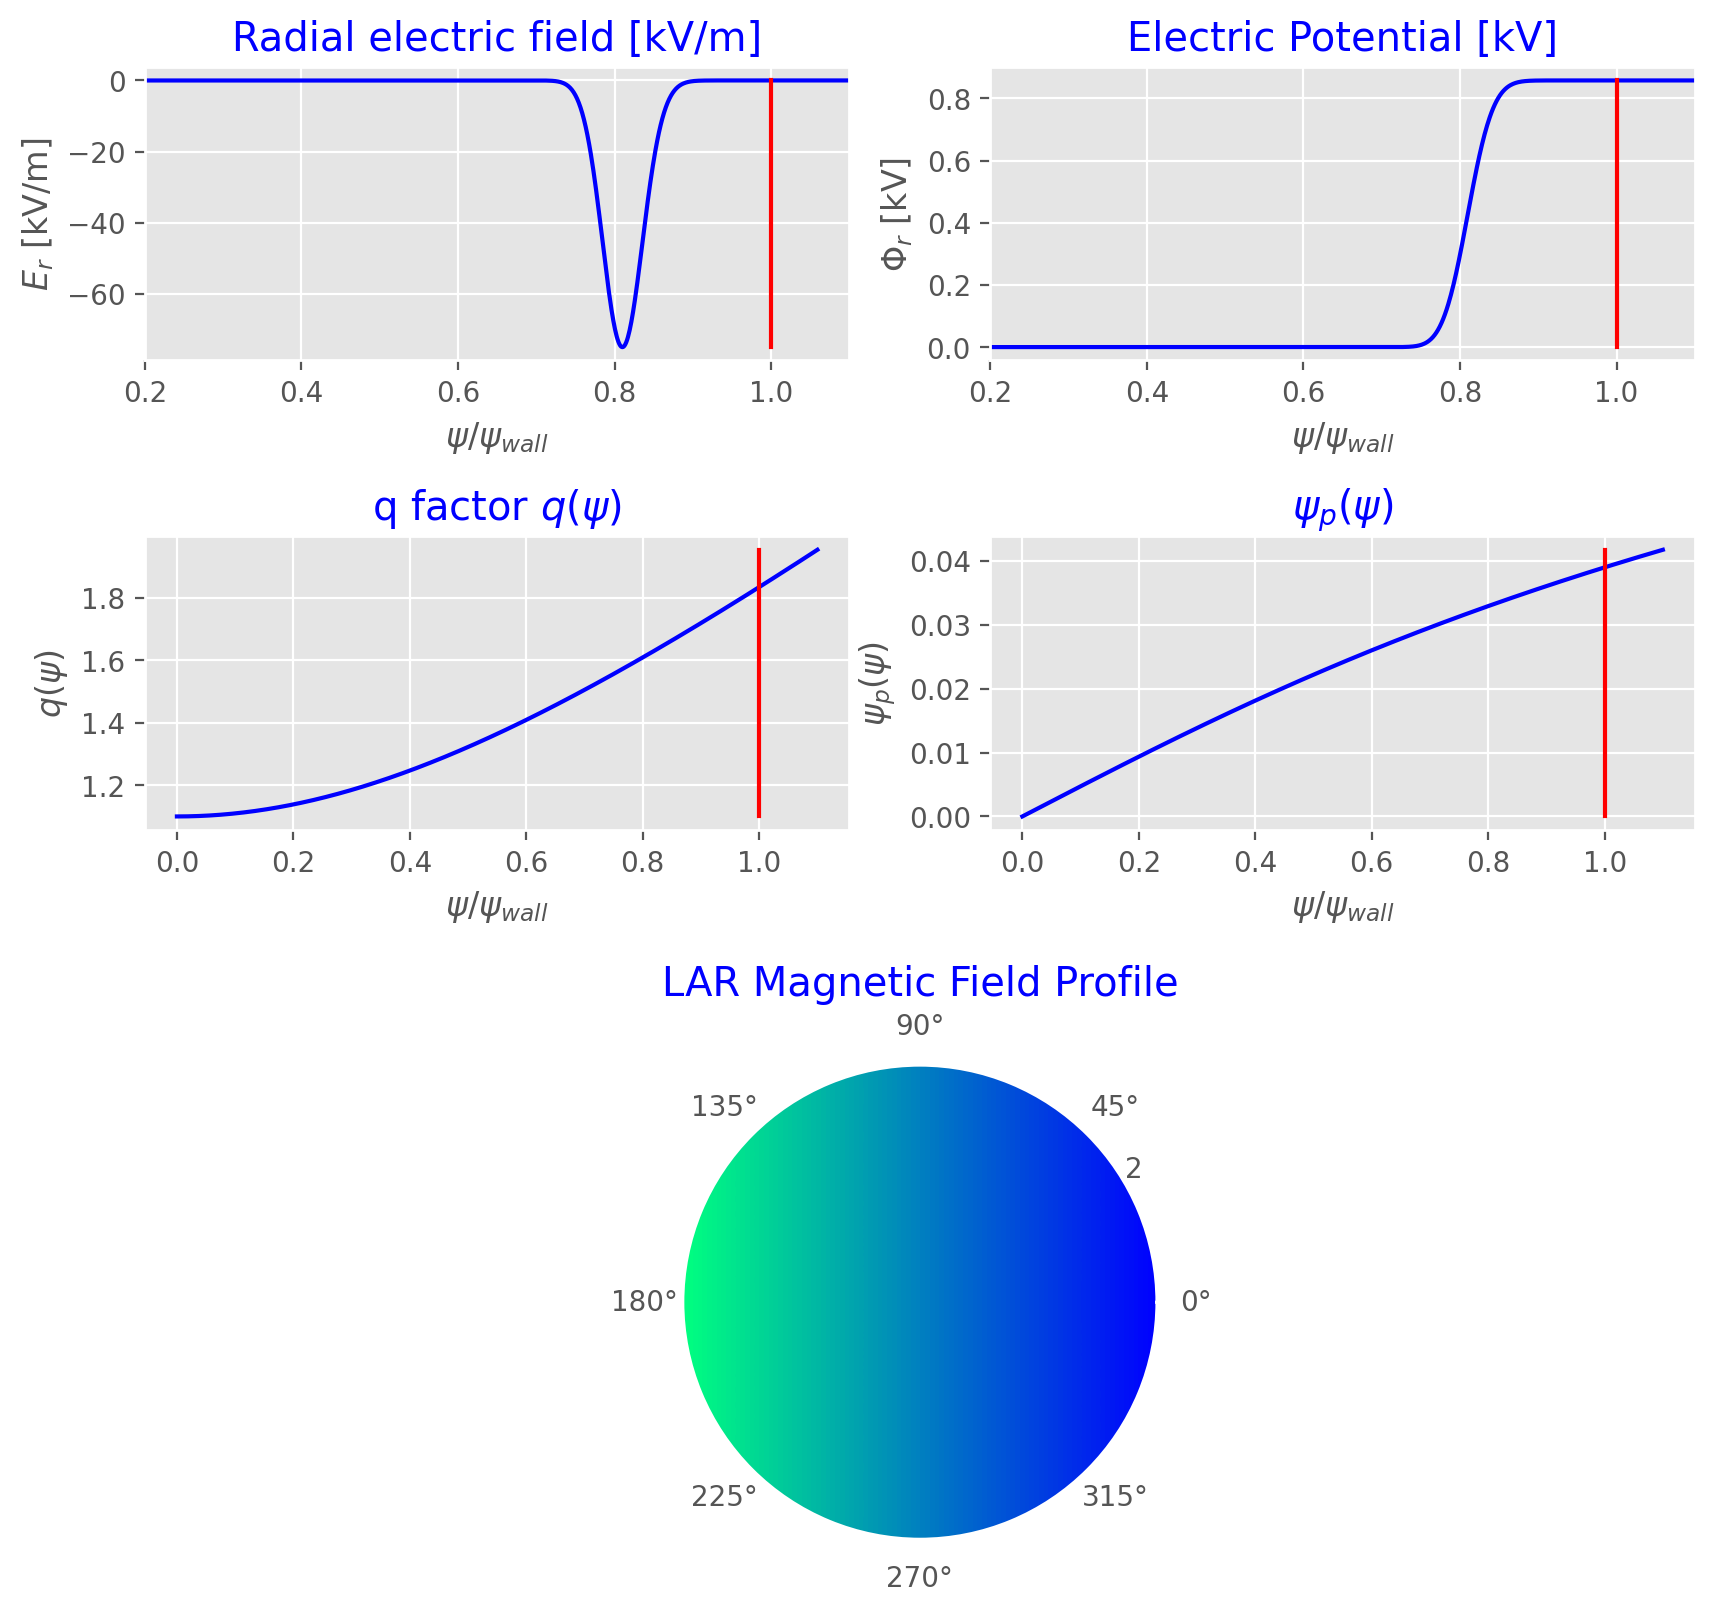

In [3]:
cwp.plot.tokamak_profile(zoom = [0.2, 1.1])

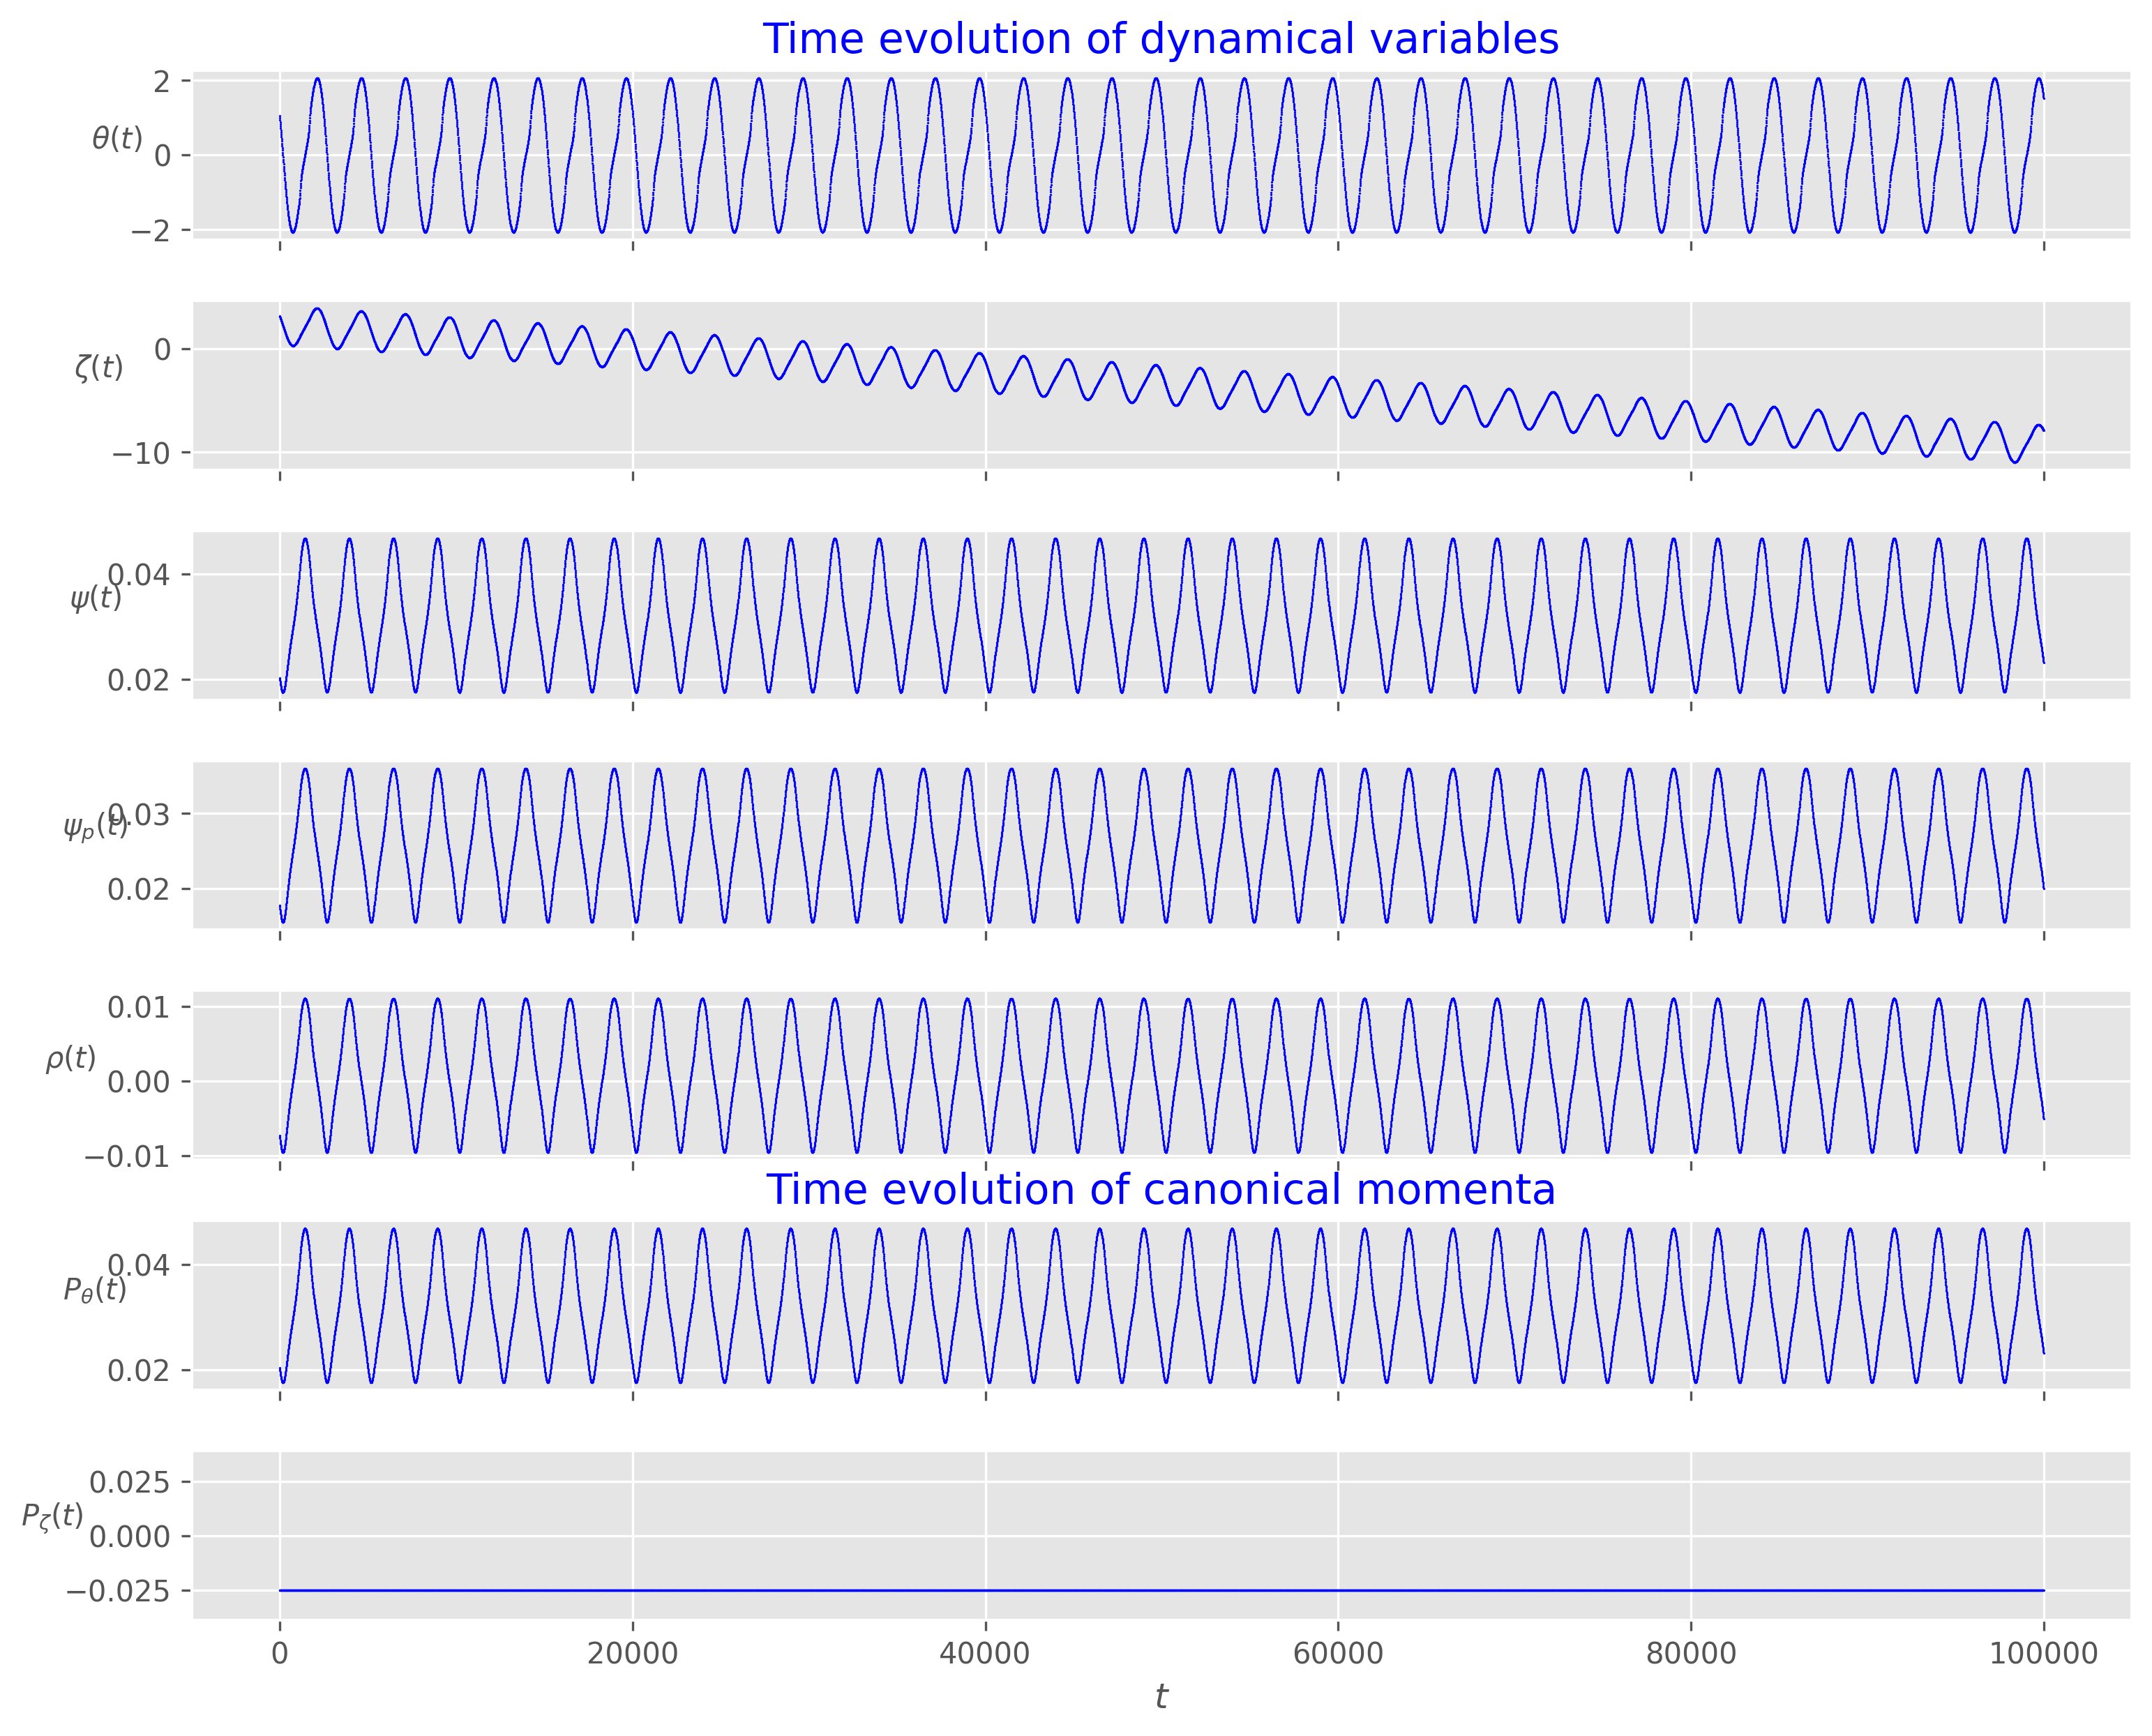

In [4]:
cwp.plot.time_evolution(percentage =10)

### Energy Contour Plots

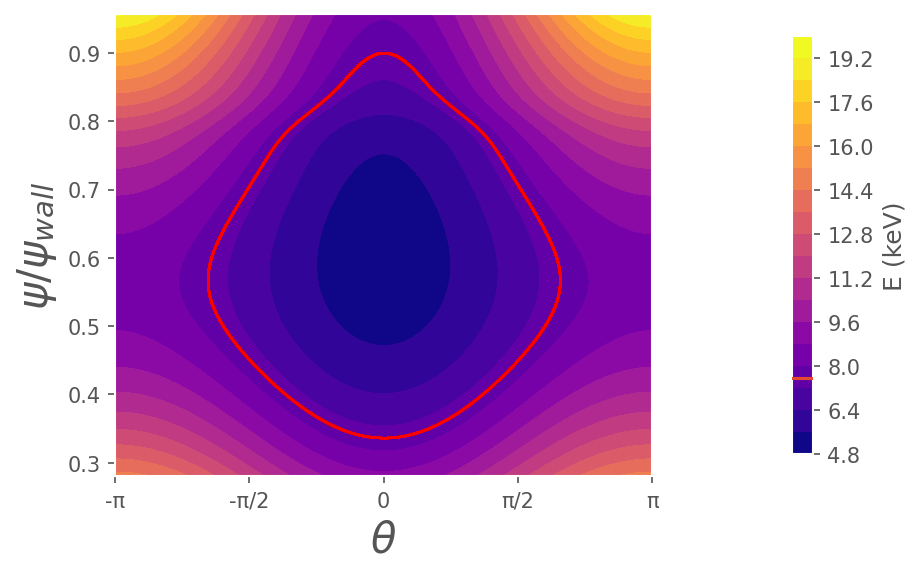

In [5]:
cwp.plot.contour_energy(
    theta_lim = [-np.pi ,np.pi], psi_lim = "auto", 
    plot_drift=True, contour_Phi = True, units = "keV", levels = 20
);

## Orbit types parabolas

As for figuring out if the particle is Lost or Confined, we need only to check if its orbit point lies in-between the 2 left parabolas.

In [6]:
cwp.plot.parabolas()
cwp.plot.orbit_point()

Parabolas dont work with Efield present.


## Torus Poincare map and 3d Torus orbits

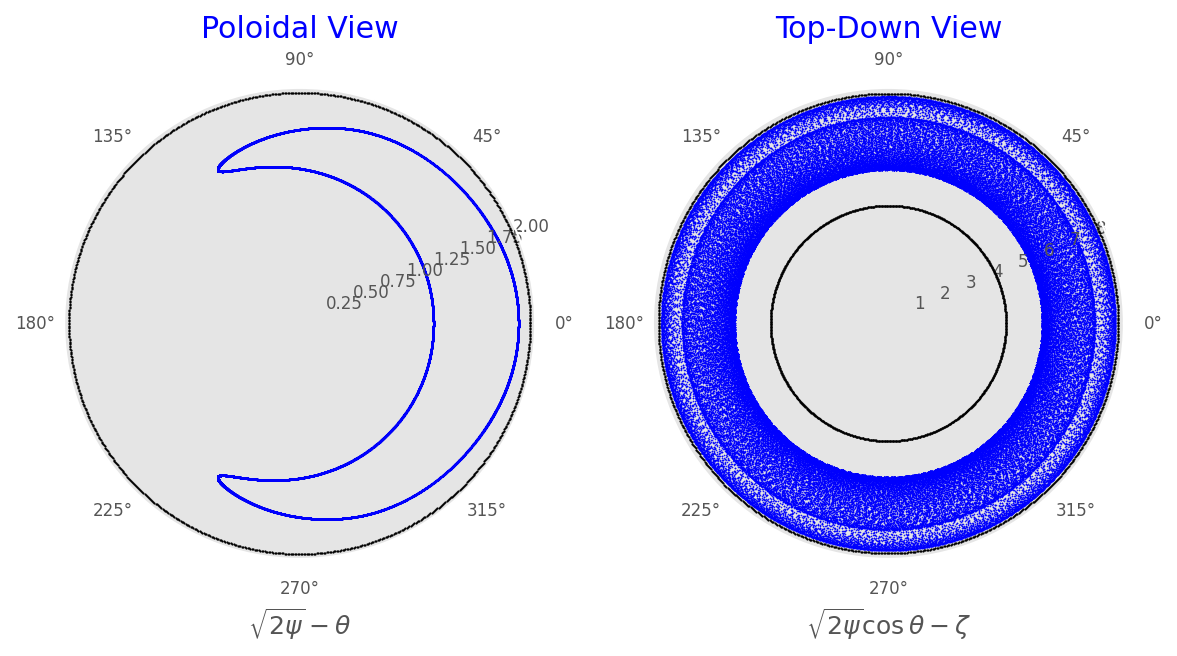

In [7]:
cwp.plot.torus2d(percentage = 100, truescale=True)

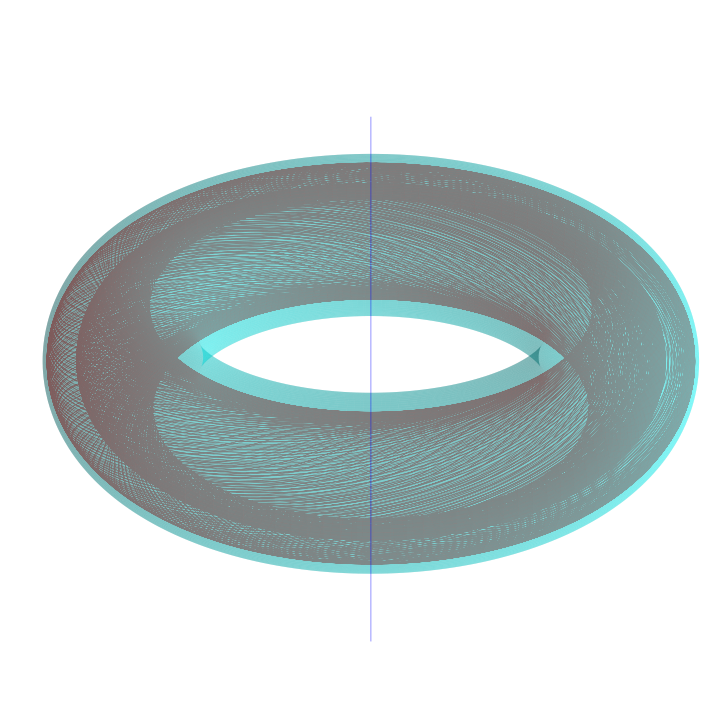

In [8]:
cwp.plot.torus3d(percentage=100, truescale=True, 
                white_background=True, hd=False,)

In [9]:
# params = {"percentage": 100, "truescale": True,
#           "min_step": 0.01, "seconds": 300}
# gcm.animate(cwp, params)

## FFT

----------------Running a single period (event locator)----------------

	Calculated θ frequency			= 1.203e+06
	Calculated zeroth ζ frequency		= 6.164e+04
	Calculated ζ fast frequency		= 1.203e+06

Calculation time: 0.0171s.

-----------------------------FFT results-------------------------------

Using the whole signal.

	Calculated θ frequency			= 1.204e+06
	5 harmonics found: ['1.204e+06Hz', '2.404e+06Hz', '3.608e+06Hz', '4.809e+06Hz', '7.216e+06Hz']

	Sample rate = 4.789e+07 samples/s.
Calculation time: 0.0013s.




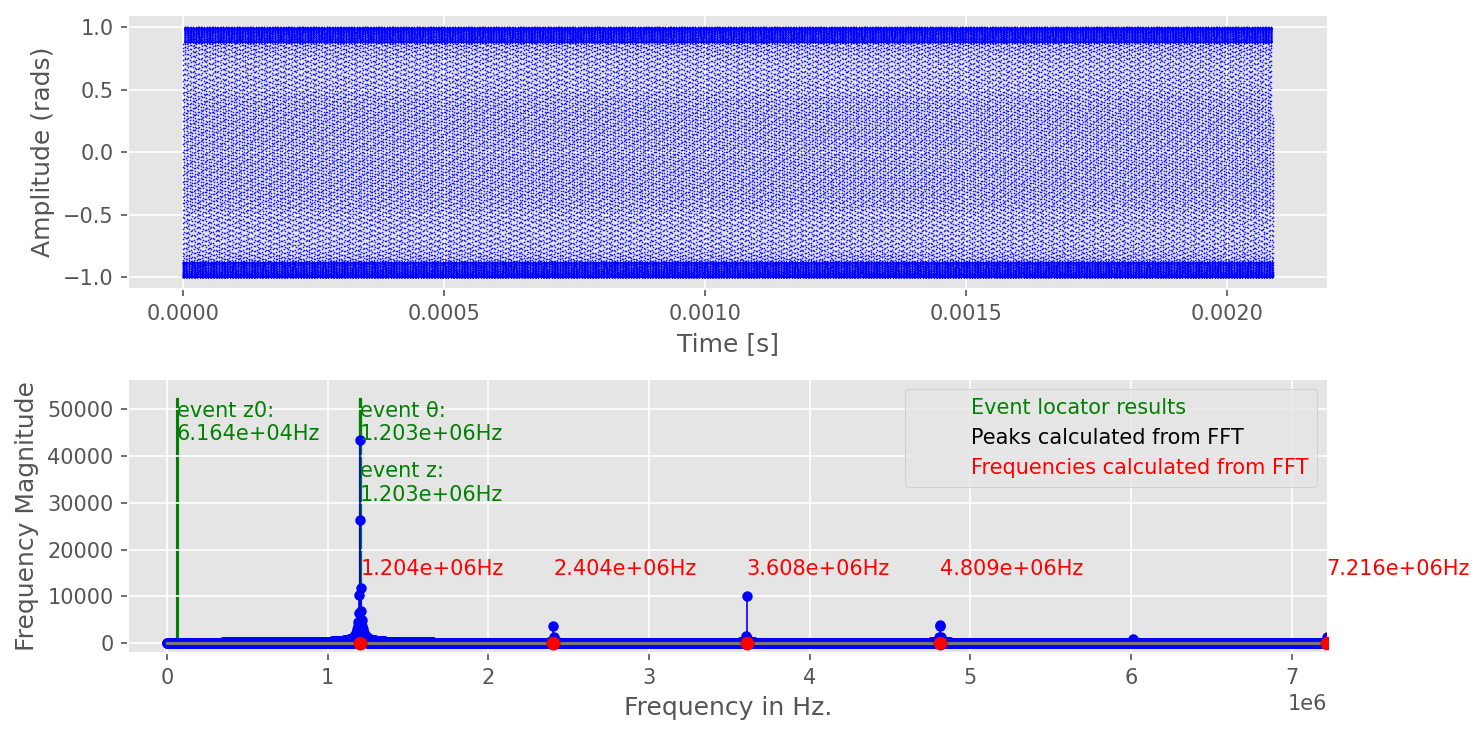

In [10]:
%matplotlib inline 
# replace "inline" with "qt" for interactive

trim_params={"periods":100, "steps_per_period":40}
cwp.freq_analysis(angle="theta", trim_params={})

----------------Running a single period (event locator)----------------

	Calculated θ frequency			= 1.203e+06
	Calculated zeroth ζ frequency		= 6.164e+04
	Calculated ζ fast frequency		= 1.203e+06

Calculation time: 0.0194s.

-----------------------------FFT results-------------------------------

Using the whole signal.

	Calculated z zeroth frequency			= 5.417e+04
	Calculated z fast frequency			= 1.201e+06
	5 harmonics found: ['1.201e+06Hz', '2.404e+06Hz', '3.608e+06Hz', '4.809e+06Hz', '6.013e+06Hz']

	Sample rate = 4.789e+07 samples/s.
Calculation time: 0.0011s.




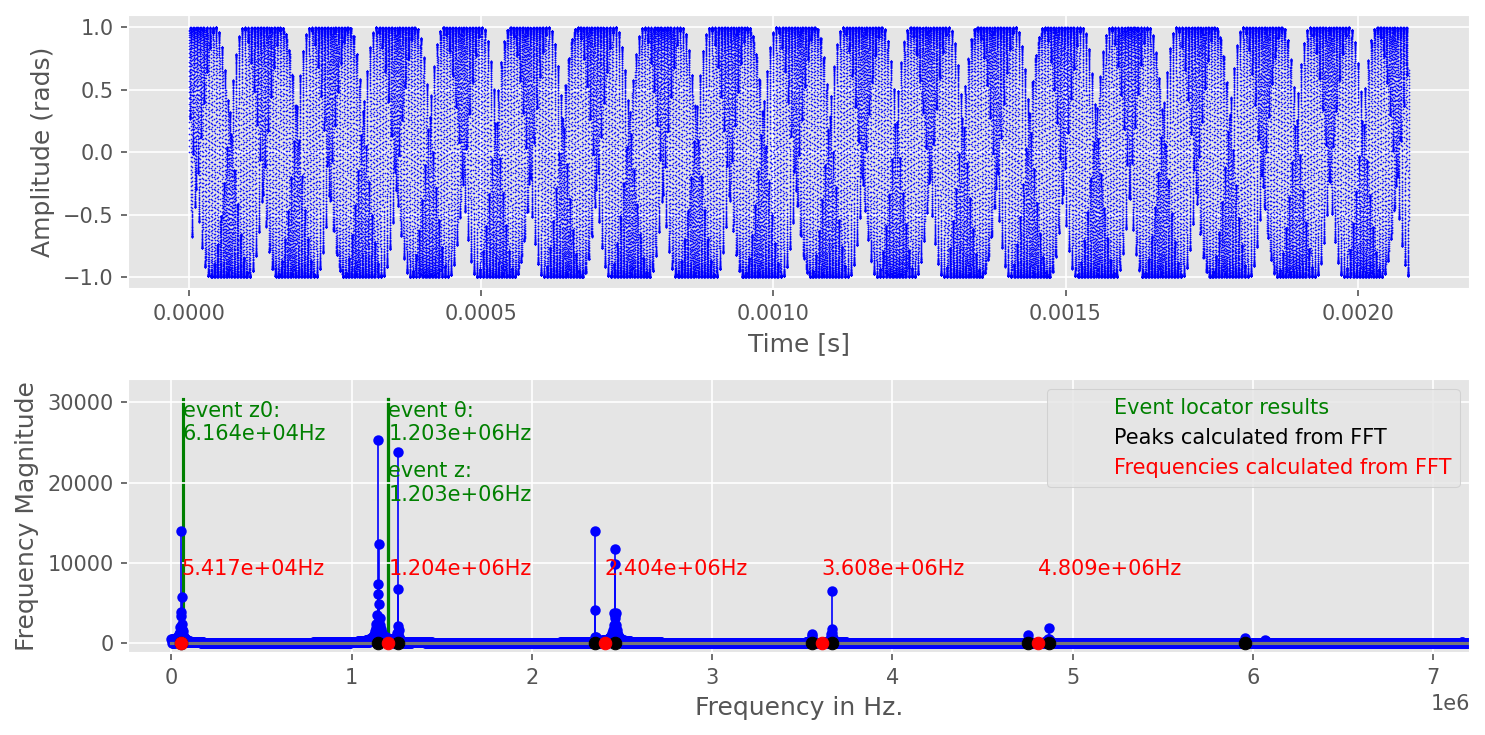

In [11]:
%matplotlib inline 
# replace "inline" with "qt" for interactive

trim_params={"periods":100, "steps_per_period":40}
cwp.freq_analysis(angle="zeta", trim_params={})